In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import pickle

from ds import Datas

In [163]:
# LOAD Datas()
file = open("../../data/PO_norm_part3_mult4.txt", "rb")
data = pickle.load(file)
file.close()


print(np.shape(data.is_optimum)) # [n_bvars, n_instances, n_Mstrategies]
print(data.M_strategies)

(7, 1000, 2)
['heuristic_PO_M', 'qiskit_M']


### Cherrypicking good (big gap) instances for IonQ runs

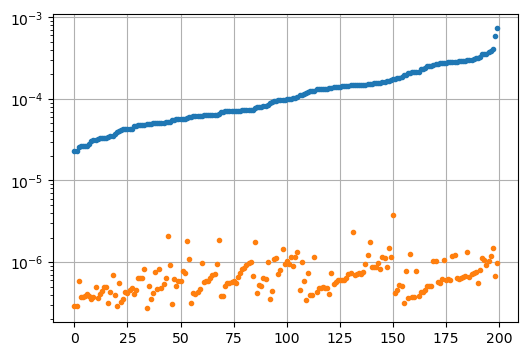

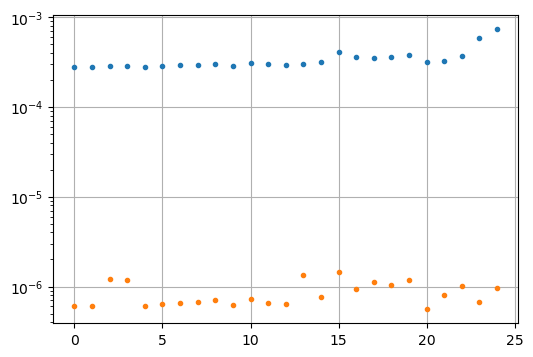

In [26]:
var_idx = -2

gaps_o = data.gap_norm[var_idx,:,0]
gaps_q = data.gap_norm[var_idx,:,1]
#gaps_b = data.gap_norm[var_idx,:,3]

idx = np.argsort(gaps_o)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
plt.plot(np.arange(len(gaps_o)), gaps_o[idx], ".", color = "C0")
plt.plot(np.arange(len(gaps_q)), gaps_q[idx], ".", color = "C1")
#plt.plot(np.arange(len(gaps_b)), gaps_b[idx], ".", color = "C2")
plt.grid()
plt.yscale("log")
#plt.ylim(7e-3, 3e-2)
plt.show()

# cherrypicking 
size_cherries = 25
ind = np.argpartition(gaps_o, -size_cherries)[-size_cherries:]

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
plt.plot(np.arange(len(ind)), gaps_o[ind], ".", color = "C0")
plt.plot(np.arange(len(ind)), gaps_q[ind], ".", color = "C1")
#plt.plot(np.arange(len(gaps_b)), gaps_b[idx], ".", color = "C2")
plt.grid()
plt.yscale("log")
#plt.ylim(7e-3, 3e-2)
plt.show()

f = open("../easy_toys_adiabevol/PO_sp500_part3_ra10_mult2/easy_inst21.txt", "w")
for i in ind:
   f.write(data.filenames[var_idx,i]+"\n")
f.close()


## Analysis

In [109]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ["o", ">", "s"]
#M_strategies = [r"$M_{SDP}$", r"$M_{l_1}$", "optimal_M", "babbush_M"]
#M_strategies = [r"$M_{SDP}$", r"$M_{l_1}$"]
M_strategies = [r"$M_{greedy}$", r"$M_{l_1}$"]
plot_M = [1, 1, 0, 0]

## M value

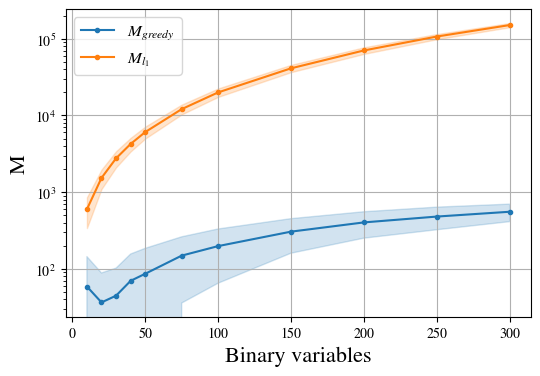

In [110]:
def statistics_M(M):
    avg = np.mean(M[:,:,:], axis = 1)
    std = np.std(M[:,:,:], axis = 1)
    return avg, std

avg_M, std_M = statistics_M(data.M)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
#ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('M', fontsize = 16)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_M[:,i], marker = ".", color = colors[i], label=M_strategies[i])
        plt.fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i],
         color = colors[i], alpha=.2)
plt.grid()
#plt.ylim(-100, 100)
plt.yscale("log")
#plt.xscale("log")
ax1.legend(fontsize = 12, loc='best')
#ax1.set_xticks(data.bvars)
plt.show()

(11, 100, 2)


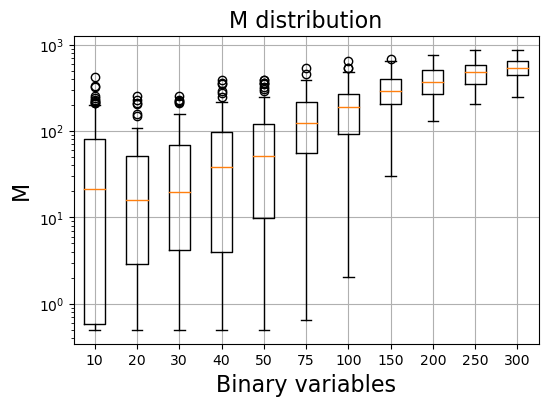

In [57]:
print(data.M.shape)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('M distribution', fontsize = 16)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('M', fontsize = 16)
box1 = ax1.boxplot(np.swapaxes(data.M[...,0], axis1=0, axis2=1), labels = data.bvars) # , patch_artist=True
#plt.ylim(0, 1)
plt.yscale("log")
plt.grid()
plt.show()

### Fitting M

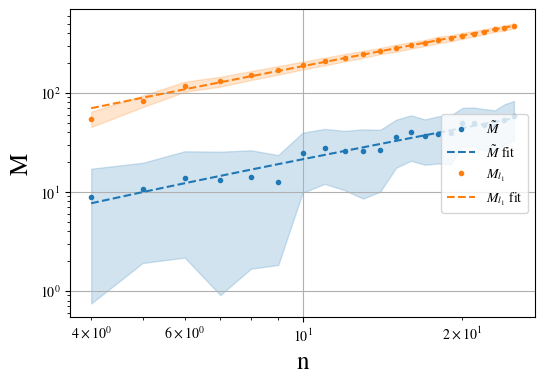

Our
par[0]:	2.278 \pm 0.121 	(5.3%)
par[1]:	-1.436 \pm 1.841 	(128.19%)
Qiskit
par[0]:	19.285 \pm 0.171 	(0.88%)
par[1]:	-7.178 \pm 2.603 	(36.26%)
theoretical
par[0]:	2.199 \pm 0.121 	(5.5%)
par[1]:	-1.204 \pm 1.844 	(153.24%)


In [29]:
f_linear = lambda n, a, b: a*n + b
f_powlaw = lambda n, a, b : a*n**b
f_inv = lambda n, a, b: a/n + b
funct = f_linear

n_parameters = 2
_, _, n_M = np.shape(data.is_feasible)

start_point = 0
end_point = -1

coef = np.ndarray((n_parameters, n_M))
coef_cov = np.ndarray((n_parameters, n_parameters, n_M))
coef_err = np.ndarray((n_parameters, n_M))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[start_point:end_point], avg_M[start_point:end_point,i])
    coef_err[:,i] = np.sqrt( np.diag(coef_cov[...,i]) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
#ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('n', fontsize = 18)
ax1.set_ylabel('M', fontsize = 18)
for i in range(n_M):
    if plot_M[i]:
        plt.plot(data.bvars, avg_M[:,i], ".", color = colors[i], label=M_strategies[i])
        plt.fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i], color = colors[i], alpha=.2)
        plt.plot(np.arange(data.bvars[0], data.bvars[-1] + 1),
                funct(np.arange(data.bvars[0], data.bvars[-1] + 1), *coef[:,i]), "--",
                color = colors[i], label=M_strategies[i]+" fit")
plt.grid()
#plt.ylim(0, 5e3)
plt.yscale("log")
plt.xscale("log")
ax1.legend(fontsize = 10, loc='center right')
#ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

words = ["Our", "Qiskit", "theoretical"]
for i in range(len(words)):
    print(words[i])
    for j in range(n_parameters):
        print(f"par[{j}]:\t{np.round(coef[j,i], 3)} \pm {np.round(coef_err[j,i], 3)} \t({np.round(np.abs(coef_err[j,i]/coef[j,i]*100), 2)}%)")

## Optimality and Feasibility percentages

In [19]:
def evaluate_optimality(data, opt_threshold = .5):
    n_bvars, n_samples, n_M_strats = np.shape(data.is_feasible)
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            for sample in range(n_samples):
                if data.is_feasible[var_idx, sample, M_idx]:
                    fc = data.fval[var_idx, sample, 0, M_idx]
                    fq = data.fval[var_idx, sample, 1, M_idx]
                    if np.abs(fc - fq) < opt_threshold: # optimum
                        data.is_optimum[var_idx, sample, M_idx] = True

def compute_errors(data, threshold_fc_zero = 1e-8):
    n_bvars, n_samples, n_M_strats = np.shape(data.is_feasible)
    is_feas_non_opt = np.logical_xor(data.is_feasible, data.is_optimum)
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            for sample in range(n_samples):
                if is_feas_non_opt[var_idx, sample, M_idx] == True:
                    fc = data.fval[var_idx, sample, 0, M_idx]
                    fq = data.fval[var_idx, sample, 1, M_idx]
                    if np.abs(fc) > threshold_fc_zero: 
                        ratio = np.abs( (fq -fc) / fc)
                    else:
                        ratio = None
                    data.relative_error[var_idx, sample, M_idx] = ratio
                    data.absolute_error[var_idx, sample, M_idx] = fq -fc

def statistics_correctness_n_feasability(data):
    '''
    Returns:
        percentage_optimal, percentage_feasible, (avg_relative_error, std_relative_error) [only among feasible non optimal solutions],
        (avg_n_violations, avg_max_violation) [only among non feasible solutions]
    '''
    n_bvars, n_samples, n_M_strats = np.shape(data.is_feasible)
    # percentages
    perc_opt = np.count_nonzero(data.is_optimum, axis=1) / n_samples
    perc_feas = np.count_nonzero(data.is_feasible, axis=1) / n_samples
    # relative errs
    is_feas_non_opt = np.logical_xor(data.is_feasible, data.is_optimum)
    avg_relative_error, std_relative_error = np.zeros((n_bvars, n_M_strats)), np.zeros((n_bvars, n_M_strats))
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            relative_errs = data.relative_error[var_idx, :, M_idx][is_feas_non_opt[var_idx, :, M_idx]]
            # discard the None for when fc ~ 0
            relative_errs = relative_errs[~np.isnan(relative_errs)]
            if len(relative_errs) > 0:
                avg_relative_error[var_idx, M_idx] = np.mean(relative_errs)
                std_relative_error[var_idx, M_idx] = np.std(relative_errs)
    # errors
    avg_error, std_error = np.zeros((n_bvars, n_M_strats)), np.zeros((n_bvars, n_M_strats))
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            absolute_err = data.absolute_error[var_idx, :, M_idx][is_feas_non_opt[var_idx, :, M_idx]]
            if len(absolute_err) > 0:
                avg_error[var_idx, M_idx] = np.mean(absolute_err)
                std_error[var_idx, M_idx] = np.std(absolute_err)
    # violations
    is_infeas = np.logical_not(data.is_feasible)
    avg_n_violations, avg_max_violation = np.zeros((n_bvars, n_M_strats)), np.zeros((n_bvars, n_M_strats))
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            n_viol = data.n_violations[var_idx, :, M_idx][is_infeas[var_idx, :, M_idx]]
            if len(n_viol) > 0:
                max_viol = data.max_violation[var_idx, :, M_idx][is_infeas[var_idx, :, M_idx]]
                avg_n_violations[var_idx, M_idx] = np.mean(n_viol)
                avg_max_violation[var_idx, M_idx] = np.mean(max_viol)
    return perc_opt, perc_feas, (avg_relative_error, std_relative_error), (avg_error, std_error), (avg_n_violations, avg_max_violation)

evaluate_optimality(data)
compute_errors(data)
perc_opt, perc_feas, (avg_relative_error, std_relative_error), (avg_absolute_error, std_absolute_error), (avg_n_violations, avg_max_violation) = statistics_correctness_n_feasability(data)

ALL was not optimally solved!


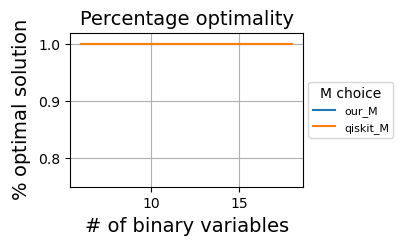

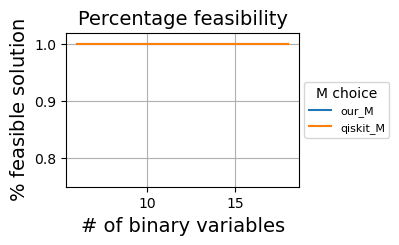

In [20]:
if np.any(data.is_optimum == 0):
    print("!!!!\tSomething was not optimally solved!")
    n_bvars, n_samples, n_Ms = np.shape(data.is_optimum)
    for i in range(n_bvars):
        print(f"Vars = {data.bvars[i]}\t solved {np.sum(data.is_optimum[i])} out of {n_samples*n_Ms}")
else:
    print("ALL was not optimally solved!")
    
    

fig = plt.figure(figsize=(3,2))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Percentage optimality', fontsize = 14)
ax1.set_xlabel('# of binary variables', fontsize = 14)
ax1.set_ylabel('$\%$ optimal solution', fontsize = 14)
plt.ylim(0, 1.1)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, perc_opt[:,i], label=M_strategies[i])
plt.ylim(.75,1.02)
plt.grid()
ax1.legend(title = 'M choice', fontsize = 8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(3,2))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Percentage feasibility', fontsize = 14)
ax1.set_xlabel('# of binary variables', fontsize = 14)
ax1.set_ylabel('$\%$ feasible solution', fontsize = 14)
plt.ylim(.75,1.02)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, perc_feas[:,i], label=M_strategies[i])
plt.grid()
ax1.legend(title = 'M choice', fontsize = 8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Errors

In [12]:
# fig = plt.figure(figsize=(6,4))
# ax1 = fig.add_subplot(1,1,1)
# ax1.set_title('Relative error (among feas non-opt)', fontsize = 22)
# ax1.set_xlabel('# of binary variables', fontsize = 22)
# ax1.set_ylabel('$|f_q-f_c / f_c|$', fontsize = 22)
# is_feas_non_opt = np.logical_xor(data.is_feasible, data.is_optimum)
# for i in range(len(M_strategies)):
#     if plot_M[i]:
#         plt.plot(data.bvars, avg_relative_error[:,i], label=M_strategies[i], color = colors[i])
#         plt.fill_between(data.bvars, avg_relative_error[:,i] - std_relative_error[:,i], avg_relative_error[:,i] + std_relative_error[:,i], alpha=.2)
# #plt.ylim(-1,5)
# plt.grid()
# ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

# fig = plt.figure(figsize=(6,4))
# ax1 = fig.add_subplot(1,1,1)
# ax1.set_title('Absolute error (among feas non-opt)', fontsize = 22)
# ax1.set_xlabel('# of binary variables', fontsize = 22)
# ax1.set_ylabel('$f_q-f_c$', fontsize = 22)
# for i in range(len(M_strategies)):
#     if plot_M[i]:
#         plt.plot(data.bvars, avg_absolute_error[:,i], label=M_strategies[i], color = colors[i])
#         plt.fill_between(data.bvars, avg_absolute_error[:,i] - std_absolute_error[:,i], np.abs(avg_absolute_error[:,i]) + std_absolute_error[:,i], alpha=.2)
# #plt.ylim(0,2)
# plt.grid()
# ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

# fig = plt.figure(figsize=(6,4))
# ax1 = fig.add_subplot(1,1,1)
# ax1.set_title('Average number violations (among non feasible)', fontsize = 22)
# ax1.set_xlabel('# of binary variables', fontsize = 22)
# for i in range(len(M_strategies)):
#     if plot_M[i]:
#         plt.plot(data.bvars, avg_n_violations[:,i], label=M_strategies[i])
# plt.grid()
# ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

# fig = plt.figure(figsize=(6,4))
# ax1 = fig.add_subplot(1,1,1)
# ax1.set_title('Average maximum violation (among non feasible)', fontsize = 22)
# ax1.set_xlabel('# of binary variables', fontsize = 22)
# for i in range(len(M_strategies)):
#     if plot_M[i]:
#         plt.plot(data.bvars, avg_max_violation[:,i], label=M_strategies[i])
# plt.grid()
# ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

## Gaps

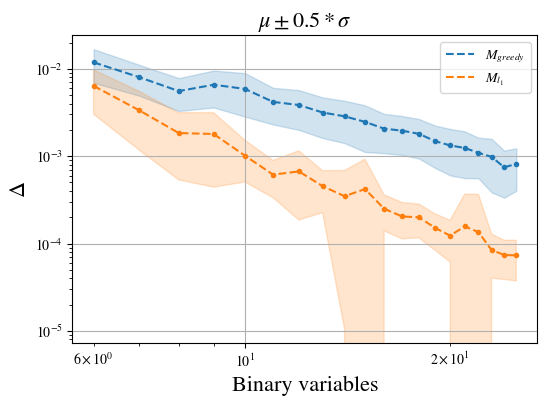

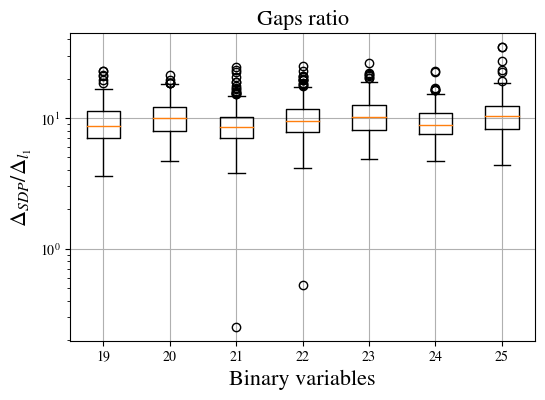

In [93]:
def statistics_gaps(gap):
    avg = np.mean(gap[:,:,:], axis = 1)
    std = np.std(gap[:,:,:], axis = 1)
    return avg, std

avg_gap, std_gap = statistics_gaps(data.gap_norm)


ratio_stddev = 0.5
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title(f'$\mu \pm {ratio_stddev}*\sigma$', fontsize = 16)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('$\Delta$', fontsize = 16)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_gap[:,i], "--", label=M_strategies[i],  color = colors[i])
        plt.plot(data.bvars, avg_gap[:,i], ".",  color = colors[i])
        plt.fill_between(data.bvars, avg_gap[:,i] - ratio_stddev*std_gap[:,i], avg_gap[:,i] + ratio_stddev*std_gap[:,i],
          color = colors[i], alpha=.2)
plt.grid()
plt.yscale("log")
plt.xscale("log")
ax1.legend(fontsize = 10, loc='upper right')
#plt.ylim(1e-5,2e-2)
plt.show()

indexes_to_plot = list(np.arange(-7, 0))   # PO_part3_ra10_mult4
#ndexes_to_plot = list(np.arange(1, 21,3)) # SPP_p25
#indexes_to_plot = list(np.arange(0, 23, 3)) # NN_deg5
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Gaps ratio', fontsize = 16)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('$\Delta_{SDP} / \Delta_{l_1}$', fontsize = 16)
box1 = ax1.boxplot(np.swapaxes(data.gap_norm[indexes_to_plot,:,0]/data.gap_norm[indexes_to_plot,:,1], axis1=0, axis2=1), labels = data.bvars[indexes_to_plot]) # , patch_artist=True
#plt.setp(box1['whiskers'], color="C0")
#plt.setp(box1['caps'], color="C0")
#plt.setp(box1["fliers"], markeredgecolor="C2")
#plt.setp(box1["boxes"], facecolor="C0")
#plt.axhline(1)
#plt.ylim(2, 4000)
plt.yscale("log")
plt.grid()
plt.show()

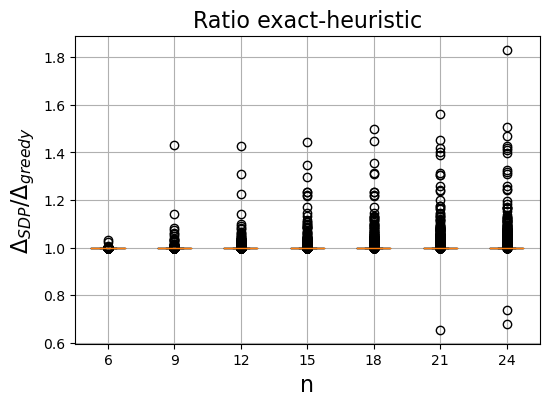

Index 630
Filename:	toys/PO_sp500_part3_ra10_mult4/24/random66642_24.lp
Filename greedy: /home/ealessan/toys/PO_sp500_part3_ra10_mult4/24/random66642_24.lp
6.521240381371795e-05
8.82391400103619e-05
232.05529849503176
157.05529850435983
Index 778
Filename:	toys/PO_sp500_part3_ra10_mult4/24/random80042_24.lp
Filename greedy: /home/ealessan/toys/PO_sp500_part3_ra10_mult4/24/random80042_24.lp
6.419827019984291e-05
9.448838641368875e-05
27.420455921411644
116.4204561033306


In [6]:

indexes_to_plot = list(np.arange(-7, 0))
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Ratio exact-heuristic', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('$\Delta_{SDP} / \Delta_{greedy}$', fontsize = 16)
ax1.boxplot(np.swapaxes(data.gap_norm[indexes_to_plot,:,0]/data_gr.gap_norm[indexes_to_plot,:,0], axis1=0, axis2=1), labels = data.bvars[indexes_to_plot])
#plt.axhline(1)
#plt.ylim(0,15)
plt.grid()
plt.show()

var = -1
ii = np.nonzero(data.gap_norm[var,:,0]/data_gr.gap_norm[var,:,0] < .99)
for i in ii[0]:
    print(f"Index {i}")
    print(f"Filename:\t{data.filenames[var, i]}")
    print(f"Filename greedy: {data_gr.filenames[var, i]}")
    print(data.gap_norm[var,i,0])
    print(data_gr.gap_norm[var,i,0])
    print(data.M[var,i,0])
    print(data_gr.M[var,i,0])


## Plots for paper

In [59]:
import matplotlib as matp

matp.rcParams['mathtext.fontset'] = 'stix'
matp.rcParams['font.family'] = 'STIXGeneral'
#matp.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [68]:
# LOAD Datas()
file = open("../../data/PO_greedy_big_norm.txt", "rb")
data = pickle.load(file)
file.close()

print(np.shape(data.is_optimum)) # [n_bvars, n_instances, n_Mstrategies]
print(data.M_strategies)

def statistics_M(M):
    avg = np.mean(M[:,:,:], axis = 1)
    std = np.std(M[:,:,:], axis = 1)
    return avg, std

avg_M, std_M = statistics_M(data.M)

(11, 100, 2)
['heuristic_PO_M', 'qiskit_M']


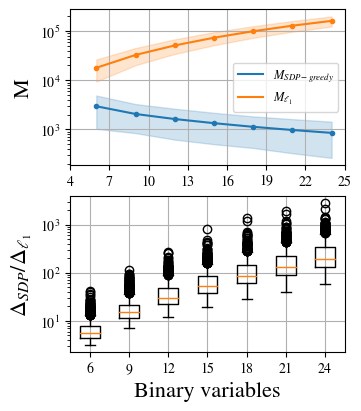

In [64]:
M_strategies = ["$M_{SDP-greedy}$", "$M_{\ell_1}$"]

figure, axis = plt.subplots(2, 1, figsize=(3.5, 4), constrained_layout=True)
  
# Top plot
#axis[0].set_xlabel('Binary variables', fontsize = 16)
axis[0].set_ylabel('M', fontsize = 16)
#axis[0].set_title("M(n)")
for i in range(len(M_strategies)):
    if plot_M[i]:
        axis[0].plot(data.bvars, avg_M[:,i], color = colors[i], label=M_strategies[i])
        axis[0].plot(data.bvars, avg_M[:,i], ".", color = colors[i])
        axis[0].fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i],
         color = colors[i], alpha=.2)
axis[0].grid()
axis[0].set_yscale("log")
#axis[0].set_xscale("log")
axis[0].set_xticks(np.arange(4, 26, 3))
axis[0].legend(fontsize = 9, loc='best')
  
# Bottom plot
indexes_to_plot = list(np.arange(-7, 0))   # PO_part3_ra10_mult4
#indexes_to_plot = list(np.arange(1, 20, 3)) # SPP_p25
#indexes_to_plot = list(np.arange(0, 24,3)) # NN_deg5
#axis[1].set_title('Gaps ratio', fontsize = 16)
axis[1].set_xlabel('Binary variables', fontsize = 16)
axis[1].set_ylabel(r'$\Delta_{SDP} / \Delta_{\ell_1}$', fontsize = 16)
#axis[1].set_ylabel(r'$\tilde{\Delta} / \Delta_{\ell_1}$', fontsize = 16)
axis[1].boxplot(np.swapaxes(data.gap_norm[indexes_to_plot,:,0]/data.gap_norm[indexes_to_plot,:,1], axis1=0, axis2=1), labels = data.bvars[indexes_to_plot])
axis[1].grid()
axis[1].set_yscale("log")
#axis[1].set_ylim(-10, 2000)
  
# Combine all the operations and display
plt.show()

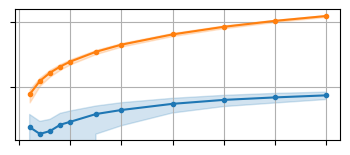

In [71]:
figM = plt.figure(figsize=(4.2,1.7))
#figM = plt.figure(figsize=(8.4,3.4))
ax = figM.add_subplot(1,1,1)
for i in range(len(M_strategies)):
    if plot_M[i]:
        ax.plot(data.bvars, avg_M[:,i], color = colors[i], label=M_strategies[i])
        ax.plot(data.bvars, avg_M[:,i], ".", color = colors[i])
        ax.fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i],
        color = colors[i], alpha=.2)
ax.grid()
ax.set_yscale("log")
#ax.set_xticks(np.arange(6, 26, 3))
ax.tick_params(labelbottom = False) 
ax.tick_params(labelleft = False) 
#ax.set_yticks([10,100])
#ax.set_xlim(4.5, 25.5)
#ax.legend(fontsize = 9, loc='best')
plt.show()

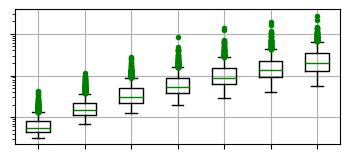

In [66]:
ylim = 40
figD = plt.figure(figsize=(4.2,1.75))
ax = figD.add_subplot(1,1,1)
indexes_to_plot = list(np.arange(-7, 0))   # PO_part3_ra10_mult4
#indexes_to_plot = list(np.arange(1, 20,3)) # SPP_p25
#indexes_to_plot = list(np.arange(0, 24,3)) # NN_deg5
#ax.set_xlabel('Binary variables', fontsize = 16)
box_plot = ax.boxplot(np.swapaxes(data.gap_norm[indexes_to_plot,:,0]/data.gap_norm[indexes_to_plot,:,1], axis1=0, axis2=1),
            sym = '.g', labels = data.bvars[indexes_to_plot])
for median in box_plot['medians']:
    median.set_color('g')
ax.grid()
ax.tick_params(labelleft = False) 
ax.tick_params(labelbottom = False) 
ax.set_yscale("log")
#ax.set_ylim(0, ylim)
plt.show()

In [29]:
# figM.savefig("../../../images/paper/M_PO_v2.pdf")
# figD.savefig("../../../images/paper/D_PO_v2.pdf")

Median:	11.389540514793303
Mean:	12.48501304756423


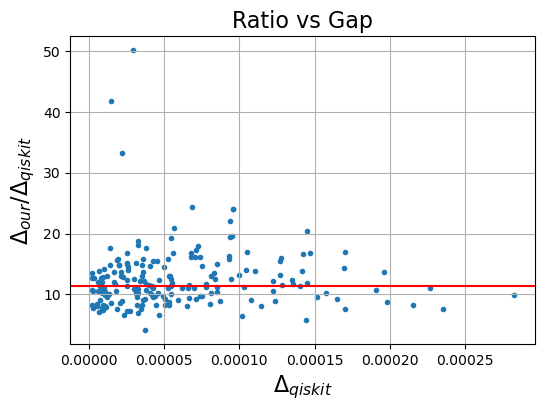

In [54]:
deltas = data.gap_norm[-1]

Mindex = 1 # Mstrategy gap I want to plot on x axis. 0 = ourM, 1 = QiskitM
m,M = min(deltas[:,Mindex]), max(deltas[:,Mindex])
med, mean = np.median(deltas[:,0]/deltas[:,1]), np.mean(deltas[:,0]/deltas[:,1])
print(f"Median:\t{med}\nMean:\t{mean}")

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Ratio vs Gap', fontsize = 16)
if Mindex == 0:
    ax1.set_xlabel('$\Delta_{our}$', fontsize = 16)
elif Mindex ==1:
    ax1.set_xlabel('$\Delta_{qiskit}$', fontsize = 16)
ax1.set_ylabel('$\Delta_{our}$/$\Delta_{qiskit}$', fontsize = 16)
plt.scatter(deltas[:,Mindex], deltas[:,0]/deltas[:,1], marker = ".")
plt.axhline(med, color = "r")
plt.grid()
plt.show()

#### Dynamical Median of Ratio vs Gap

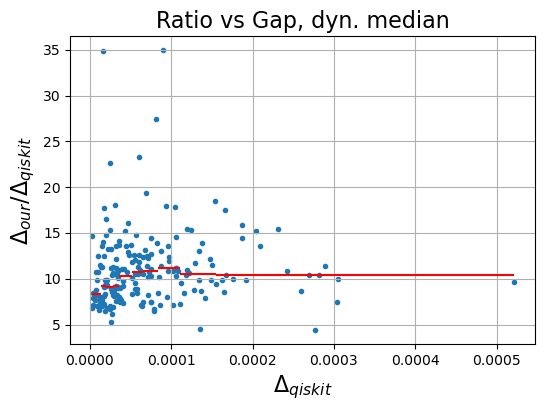

In [22]:
deltas = data.gap_norm[-1]
Mindex = 1  # M strategy to compare to (x axis will be gap of this Mindex)
n_bins = 10

def dyn_median_equisp_bin(deltas):
    d_m,d_M = min(deltas[:,Mindex]), max(deltas[:,Mindex])
    d_spaces = np.linspace(d_m, d_M, n_bins+1)
    medians = np.zeros((n_bins))
    n_samples, _ = np.shape(deltas)
    for i in range(n_bins):
        di_m, di_M = d_spaces[i], d_spaces[i+1]
        ratios = []
        for j in range(n_samples):
            if deltas[j,Mindex] >= di_m and deltas[j,Mindex] < di_M:
                ratios.append(deltas[j,0]/deltas[j,1])
        ratios = np.array(ratios)
        medians[i] = np.median(ratios)
    return d_spaces, medians

def dyn_median_diff_bin(deltas):
    d_m,d_M = min(deltas[:,Mindex]), max(deltas[:,Mindex])
    d_spaces = np.zeros(n_bins+1)
    d_spaces[0] = d_m
    medians = np.zeros((n_bins))
    n_samples, _ = np.shape(deltas)
    samxbin = int(n_samples/n_bins)
    if samxbin*n_bins != n_samples:
        print("The number of bins doesn't equally divide the whole dataset, some samples may be left out")

    d_args = np.argsort(deltas[:, Mindex])
    for i in range(n_bins):
        args = d_args[i*samxbin : (i+1)*samxbin]
        d_spaces[i+1] = deltas[args[-1], Mindex]
        ratios = []
        for j in range(samxbin):
            idx = args[j]
            ratios.append(deltas[idx,0]/deltas[idx,1])
        ratios = np.array(ratios)
        medians[i] = np.median(ratios)
    return d_spaces, medians

med_ratio = np.median(deltas[:,0]/deltas[:,1])
#d_spaces, medians = dyn_median_equisp_bin(deltas)
d_spaces, medians = dyn_median_diff_bin(deltas)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Ratio vs Gap, dyn. median', fontsize = 16)
ax1.set_xlabel('$\Delta_{qiskit}$', fontsize = 16)
ax1.set_ylabel('$\Delta_{our}$/$\Delta_{qiskit}$', fontsize = 16)
plt.scatter(deltas[:,Mindex], deltas[:,0]/deltas[:,1], marker = ".")
#plt.axhline(med_ratio, color = "b")
for i in range(n_bins):
    plt.hlines(medians[i], xmin = d_spaces[i], xmax = d_spaces[i+1], color = "r")
    #plt.vlines(d_spaces[i], 0, 1200)
plt.grid()
plt.show()

### Fit of gaps

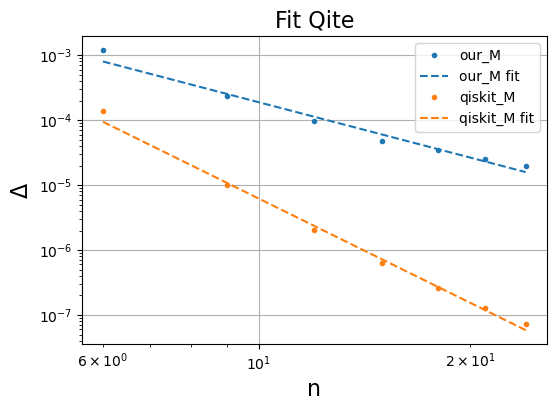

Our fit: 0.13 x^-2.83
par[0]:	0.127 \pm 0.477 	(374.92%)
par[1]:	-2.828 \pm 1.374 	(48.57%)
Qiskit fit: 1.32 x^-5.33
par[0]:	1.319 \pm 3.266 	(247.6%)
par[1]:	-5.327 \pm 0.916 	(17.19%)


In [80]:
f_pl = lambda x, a, b : a*x**b
f_exp = lambda x, a, b : a*b**x
funct = f_pl

n_parameters = 2
startpoint = 0
n_M = 2

coef = np.ndarray((n_parameters, n_M))
coef_cov = np.ndarray((n_parameters, n_parameters, n_M))
coef_err = np.ndarray((n_parameters, n_M))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[startpoint:], avg_gap_qite[startpoint:,i],
                                sigma = std_gap_qite[startpoint:,i],
                                absolute_sigma = True)
    coef_err[:,i] = np.sqrt(np.diag(coef_cov[...,i]))
# sigma in curve_fit gives the uncertainty in ydata

def RSS(x, y, f):
    return np.sum( np.square(y - f(x)) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Fit Qite', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('$\Delta$', fontsize = 16)
for i in range(n_M):
    if plot_M[i]:
        plt.plot(data.bvars, avg_gap_qite[:,i], ".", label=M_strategies[i],  color = colors[i])
        plt.plot(data.bvars, funct(data.bvars, *coef[:,i]), "--", color = colors[i], label=M_strategies[i]+" fit")
plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-5, 3e-2)
#plt.xlim(9, 26)
ax1.legend(fontsize = 10, loc='upper right')
plt.show() 


word = ["Our", "Qiskit", "Optimal"]
for i in range(n_M):
    print(f"{word[i]} fit: {np.round(coef[0,i], 2)} x^{np.round(coef[1,i], 2)}")
    for j in range(2):
        print(f"par[{j}]:\t{np.round(coef[j,i], 3)} \pm {np.round(coef_err[j,i], 3)} \t({np.round(np.abs(coef_err[j,i]/coef[j,i]*100), 2)}%)")

### Glue together Datas instances by bvars or by Mstrategy

In [16]:
## interleaving

file = open("../../data/PO_greedy_big_norm.txt", "rb")
data_base = pickle.load(file)
file.close()

file = open("../../data/PO_greedy_big_norm_75.txt", "rb")
data_inter = pickle.load(file)
file.close()

inter_index = 5

def interleave_datas_bybvars(data_base, data_inter, inter_index, length_inter = 1):
    _, n_samples, _ = np.shape(data_inter.is_optimum)
    bvars = np.append( np.append(data_base.bvars[:inter_index], data_inter.bvars), data_base.bvars[inter_index:])
    M_strats = data_base.M_strategies
    data = Datas(bvars, n_samples, M_strats)

    data.filenames[: inter_index] = data_base.filenames[:inter_index]
    data.filenames[inter_index : inter_index+length_inter] = data_inter.filenames
    data.filenames[inter_index+length_inter :] = data_base.filenames[inter_index:]

    data.gap_norm[: inter_index] = data_base.gap_norm[:inter_index]
    data.gap_norm[inter_index : inter_index+length_inter] = data_inter.gap_norm
    data.gap_norm[inter_index+length_inter :] = data_base.gap_norm[inter_index:]

    data.fval[: inter_index] = data_base.fval[:inter_index]
    data.fval[inter_index : inter_index+length_inter] = data_inter.fval
    data.fval[inter_index+length_inter :] = data_base.fval[inter_index:]

    data.M[: inter_index] = data_base.M[:inter_index]
    data.M[inter_index : inter_index+length_inter] = data_inter.M
    data.M[inter_index+length_inter :] = data_base.M[inter_index:]

    data.is_optimum[: inter_index] = data_base.is_optimum[:inter_index]
    data.is_optimum[inter_index : inter_index+length_inter] = data_inter.is_optimum
    data.is_optimum[inter_index+length_inter :] = data_base.is_optimum[inter_index:]

    data.is_feasible[: inter_index] = data_base.is_feasible[:inter_index]
    data.is_feasible[inter_index : inter_index+length_inter] = data_inter.is_feasible
    data.is_feasible[inter_index+length_inter :] = data_base.is_feasible[inter_index:]

    data.relative_error[: inter_index] = data_base.relative_error[:inter_index]
    data.relative_error[inter_index : inter_index+length_inter] = data_inter.relative_error
    data.relative_error[inter_index+length_inter :] = data_base.relative_error[inter_index:]

    data.absolute_error[: inter_index] = data_base.absolute_error[:inter_index]
    data.absolute_error[inter_index : inter_index+length_inter] = data_inter.absolute_error
    data.absolute_error[inter_index+length_inter :] = data_base.absolute_error[inter_index:]

    data.n_violations[: inter_index] = data_base.n_violations[:inter_index]
    data.n_violations[inter_index : inter_index+length_inter] = data_inter.n_violations
    data.n_violations[inter_index+length_inter :] = data_base.n_violations[inter_index:]

    data.max_violation[: inter_index] = data_base.max_violation[:inter_index]
    data.max_violation[inter_index : inter_index+length_inter] = data_inter.max_violation
    data.max_violation[inter_index+length_inter :] = data_base.max_violation[inter_index:]
    return data


data = interleave_datas_bybvars(data_base, data_inter, inter_index)

file = open("../../data/PO_greedy_big_norm_tryinterleave.txt", "wb")
pickle.dump(data, file)
file.close()

In [12]:
## adding

file = open("../../data/PO_greedy_big_norm.txt", "rb")
data_base = pickle.load(file)
file.close()

file = open("../../data/PO_greedy_big_norm_300.txt", "rb")
data_extend = pickle.load(file)
file.close()

bvars_extend = [300]

def glue_datas_bybvars(data_base, data_extend, bvars_extend):
    break_idx = len(bvars_extend)
    _, n_samples, _ = np.shape(data_extend.is_optimum)
    bvars = np.append(data_base.bvars, bvars_extend)
    M_strats = data_base.M_strategies
    data = Datas(bvars, n_samples, M_strats)

    data.filenames[:- break_idx ] = data_base.filenames
    data.filenames[- break_idx :] = data_extend.filenames
    data.gap_norm[:- break_idx ] = data_base.gap_norm
    data.gap_norm[- break_idx :] = data_extend.gap_norm
    data.fval[:- break_idx ] = data_base.fval
    data.fval[- break_idx :] = data_extend.fval
    data.M[:- break_idx ] = data_base.M
    data.M[- break_idx :] = data_extend.M
    data.is_optimum[:- break_idx ] = data_base.is_optimum
    data.is_optimum[- break_idx :] = data_extend.is_optimum
    data.is_feasible[:- break_idx ] = data_base.is_feasible
    data.is_feasible[- break_idx :] = data_extend.is_feasible
    data.relative_error[:- break_idx ] = data_base.relative_error
    data.relative_error[- break_idx :] = data_extend.relative_error
    data.absolute_error[:- break_idx ] = data_base.absolute_error
    data.absolute_error[- break_idx :] = data_extend.absolute_error
    data.n_violations[:- break_idx ] = data_base.n_violations
    data.n_violations[- break_idx :] = data_extend.n_violations
    data.max_violation[:- break_idx ] = data_base.max_violation
    data.max_violation[- break_idx :] = data_extend.max_violation
    return data



def glue_datas_Mmethod(data_base, data_extend):
    break_idx = 1
    _, n_samples, n_M_strategies = np.shape(data_base.is_optimum)
    data = Datas(data_base.bvars, n_samples, n_M_strategies + 1)
    data.gap[..., :- break_idx ] = data_base.gap
    data.gap[..., - break_idx :] = data_extend.gap
    data.gap_norm[...,:- break_idx ] = data_base.gap_norm
    data.gap_norm[...,- break_idx :] = data_extend.gap_norm
    data.gap_minimal[...,:- break_idx ] = data_base.gap_minimal
    data.gap_minimal[...,- break_idx :] = data_extend.gap_minimal
    data.fval[...,:- break_idx ] = data_base.fval
    data.fval[...,- break_idx :] = data_extend.fval
    data.M[...,:- break_idx ] = data_base.M
    data.M[...,- break_idx :] = data_extend.M
    data.is_optimum[...,:- break_idx ] = data_base.is_optimum
    data.is_optimum[...,- break_idx :] = data_extend.is_optimum
    data.is_feasible[...,:- break_idx ] = data_base.is_feasible
    data.is_feasible[...,- break_idx :] = data_extend.is_feasible
    data.relative_error[...,:- break_idx ] = data_base.relative_error
    data.relative_error[...,- break_idx :] = data_extend.relative_error
    data.absolute_error[...,:- break_idx ] = data_base.absolute_error
    data.absolute_error[...,- break_idx :] = data_extend.absolute_error
    data.n_violations[...,:- break_idx ] = data_base.n_violations
    data.n_violations[...,- break_idx :] = data_extend.n_violations
    data.max_violation[...,:- break_idx ] = data_base.max_violation
    data.max_violation[...,- break_idx :] = data_extend.max_violation
    data.time[...,:- break_idx ] = data_base.time
    data.time[...,- break_idx :] = data_extend.time
    return data

data = glue_datas_bybvars(data_base, data_extend, bvars_extend)
#data = glue_datas_Mmethod(data_base, data_extend)

file = open("../../data/PO_greedy_big_norm_final.txt", "wb")
pickle.dump(data, file)
file.close()